In [1]:
from astropy.io import fits
from astropy.nddata import Cutout2D
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm

from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import matplotlib.font_manager as fm

In [2]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


def deprojection(inputarray,h0,r0,alpha,inc,PA,dist,extent,resolution,rebinyes=True):
    pix = np.tan((resolution/10)*np.pi/180)*dist
    print('AU/Pixel = ',pix)
    
    rotarray = ndimage.rotate(inputarray,PA)
    interparray = ndimage.zoom(rotarray,(10,10))
    centrepoint = (len(interparray[0])/2,len(interparray)/2)
    
    outarray = np.ones(interparray.shape)
    
    R = []
    xy = []
    for y in tqdm(range(len(interparray))):
        for x in range(len(interparray[0])):
            xy.append((x-centrepoint[0],y-centrepoint[1]))
            rpix = np.sqrt(np.abs(x-centrepoint[0])**2 + np.abs(y-centrepoint[1])**2)
            r = rpix * pix
            R.append(r)
            if r < extent:
                u = h0*(r/r0)**alpha * np.sin(inc*np.pi/180)
                ux = x
                uy = y + round(u/pix)
                
                outarray[uy][ux]=interparray[y][x]

    if rebinyes:
        
        rebinarray = rebin(outarray, inputarray.shape)
        finalarray = ndimage.zoom(rebinarray,(1/np.cos(inc*np.pi/180),1))
        finalarray = np.array(Cutout2D(finalarray,(len(finalarray[0])/2,len(finalarray)/2),(len(inputarray[0]),len(inputarray))).data)
    
    else:
        finalarray = ndimage.zoom(outarray,(1/np.cos(inc*np.pi/180),1))
    finalarray = np.array(Cutout2D(finalarray,(len(finalarray[0])/2,len(finalarray)/2),(inputarray.shape[0],inputarray.shape[1])).data)
    fig, ax = plt.subplots(1,3,figsize=(9,3))

    
    for plot in range(len(ax)):
        ax[plot].tick_params(
        axis='both',          # changes apply to both axes
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False, 
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False)
    fontprops = fm.FontProperties(size=8)
    ax[0].imshow(rotarray,origin='lower',cmap='inferno',extent=[-rotarray.shape[0]/2*4.53298,
                                                               rotarray.shape[0]/2*4.53298,
                                                               -rotarray.shape[1]/2*4.53298,
                                                               rotarray.shape[1]/2*4.53298])
    ax[0].set_title('Rotated')

    scalebar = AnchoredSizeBar(ax[0].transData,
                           74, '0.2"\n74AU', 'lower left', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=6,
                           fontproperties=fontprops
                           )
    ax[0].add_artist(scalebar)
    ax[1].imshow(outarray,origin='lower',cmap='inferno',extent=[-outarray.shape[0]/2*0.453298,
                                                               outarray.shape[0]/2*0.453298,
                                                               -outarray.shape[1]/2*0.453298,
                                                               outarray.shape[1]/2*0.453298])
    ax[1].set_title('Flattened')
    scalebar = AnchoredSizeBar(ax[1].transData,
                           74, '0.2"\n74AU', 'lower left', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=6,
                           fontproperties=fontprops
                           )
    ax[1].add_artist(scalebar)
    ax[2].imshow(finalarray,origin='lower',cmap='inferno',extent=[-finalarray.shape[0]/2*4.53298,
                                                               finalarray.shape[0]/2*4.53298,
                                                               -finalarray.shape[1]/2*4.53298,
                                                               finalarray.shape[1]/2*4.53298])
    
    ax[2].set_title('Deprojected (Stretched)')
    scalebar = AnchoredSizeBar(ax[2].transData,
                           74, '0.2"\n74AU', 'lower left', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=6,
                           fontproperties=fontprops
                           )
    ax[2].add_artist(scalebar)
    
    return finalarray


'''
def olddeprojection(inputarray,h0,r0,alpha,inc,PA,dist,extent,resolution):
    pix = np.tan((resolution/10)*np.pi/180)*dist
    print('AU/Pixel = ',pix)
    
    rotarray = ndimage.rotate(inputarray,22.11)
    interparray = ndimage.zoom(rotarray,(10,10))
    centrepoint = (len(interparray[0])/2,len(interparray)/2)
    
    outarray = np.ones(interparray.shape)
    
    R = []
    xy = []
    for y in tqdm(range(len(interparray))):
        for x in range(len(interparray[0])):
            xy.append((x-centrepoint[0],y-centrepoint[1]))
            rpix = np.sqrt(np.abs(x-centrepoint[0])**2 + np.abs(y-centrepoint[1])**2)
            r = rpix * pix
            R.append(r)
            if r < extent:
                u = (h0/r0)*r**alpha * np.sin(inc*np.pi/180)
                ux = x
                uy = y + round(u/pix)
                
                outarray[uy][ux]=interparray[y][x]
    rebinarray = rebin(outarray, inputarray.shape)
    finalarray = ndimage.zoom(rebinarray,(1/np.cos(inc*np.pi/180),1))
    finalarray = np.array(Cutout2D(finalarray,(len(finalarray[0])/2,len(finalarray)/2),(len(inputarray[0]),len(inputarray))).data)
    
    fig, ax = plt.subplots(1,3,figsize=(9,16))
    ax[0].imshow(rotarray,origin='lower',cmap='inferno',extent=[-rotarray.shape[0]/2*4.53298,
                                                               rotarray.shape[0]/2*4.53298,
                                                               -rotarray.shape[1]/2*4.53298,
                                                               rotarray.shape[1]/2*4.53298])
    ax[1].imshow(rebinarray,origin='lower',cmap='inferno',extent=[-rebinarray.shape[0]/2*4.53298,
                                                               rebinarray.shape[0]/2*4.53298,
                                                               -rebinarray.shape[1]/2*4.53298,
                                                               rebinarray.shape[1]/2*4.53298])
    ax[2].imshow(finalarray,origin='lower',cmap='inferno',extent=[-finalarray.shape[0]/2*4.53298,
                                                               finalarray.shape[0]/2*4.53298,
                                                               -finalarray.shape[1]/2*4.53298,
                                                               finalarray.shape[1]/2*4.53298])

    
    return finalarray

'''

print('Blah')

Blah


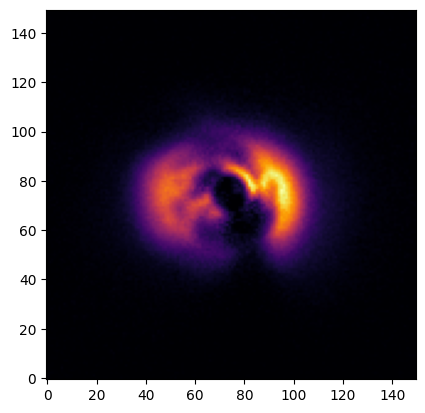

In [3]:
ATPyx = fits.open('fits/AT_Pyx_2024-01-17_Q_phi.fits')[0].data


ATPyx = np.array(Cutout2D(ATPyx,(len(ATPyx[0])/2,len(ATPyx)/2),(150,150)).data)

plt.imshow(ATPyx,origin='lower',cmap='inferno',vmin=0)


AU/Pixel =  0.45329826770346676


100%|███████████████████████████████████████| 1950/1950 [00:24<00:00, 79.14it/s]


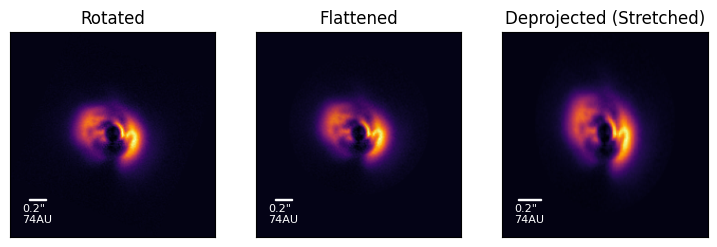

In [6]:
ATPyxDeproj = deprojection(ATPyx,
                          h0=0.1617*100,
                          r0=100,
                          alpha=1.219,
                          inc=38.5,
                          PA=22.11,
                          dist=7.632e7,
                          extent=300,
                          resolution=3.40305e-6,)
#plt.savefig('Deprojection.pdf',bbox_inches='tight')

AU/Pixel =  0.45329826770346676


100%|███████████████████████████████████████| 1950/1950 [00:23<00:00, 84.58it/s]


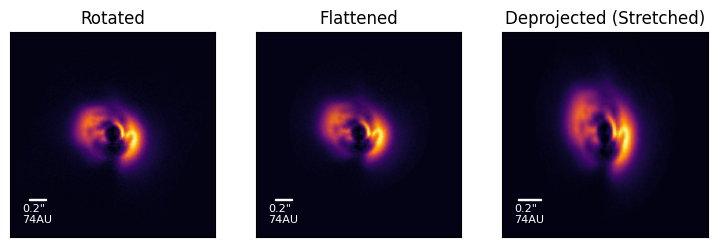

In [9]:
ATPyxDeproj45 = deprojection(ATPyx,
                          h0=0.1617*100,
                          r0=100,
                          alpha=1.219,
                          inc=45,
                          PA=22.11,
                          dist=7.632e7,
                          extent=300,
                          resolution=3.40305e-6,)
#plt.savefig('Deprojection.pdf',bbox_inches='tight')

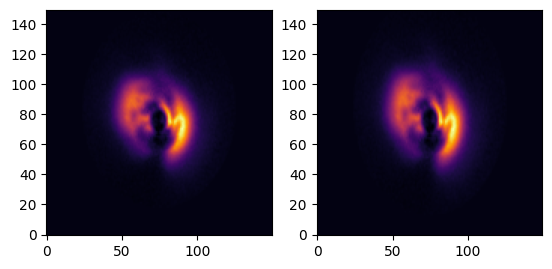

In [10]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(ATPyxDeproj,cmap='inferno',origin='lower')

ax[1].imshow(ATPyxDeproj45,cmap='inferno',origin='lower')

"\nhdu = fits.PrimaryHDU(data=ATPyxDeproj)\nhdul = fits.HDUList([hdu])\nhdu.writeto('ATPyxDeprojwithCutout.fits')\n"

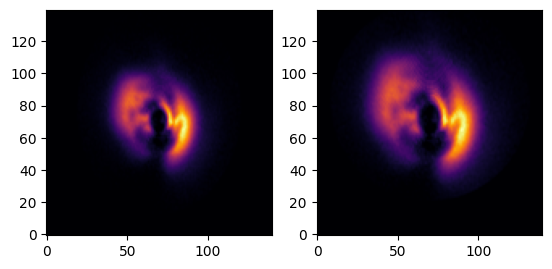

In [29]:
ATPyxOldDeproj = fits.open('fits/squaredanimage.fits')[0].data

ATPyxDeproj = np.array(Cutout2D(ATPyxDeproj,(len(ATPyxDeproj[0])/2,len(ATPyxDeproj)/2),
                                (len(ATPyxOldDeproj[0]),len(ATPyxOldDeproj))).data)


fig, ax = plt.subplots(1,2)

ax[0].imshow(ATPyxDeproj,origin='lower',cmap='inferno',vmin=0)


ax[1].imshow(ATPyxOldDeproj,origin='lower',cmap='inferno',vmin=0)

'''
hdu = fits.PrimaryHDU(data=ATPyxDeproj)
hdul = fits.HDUList([hdu])
hdu.writeto('ATPyxDeprojwithCutout.fits')
'''



AU/Pixel =  0.45329826770346676


100%|██████████████████████████████████████| 1950/1950 [00:15<00:00, 124.29it/s]


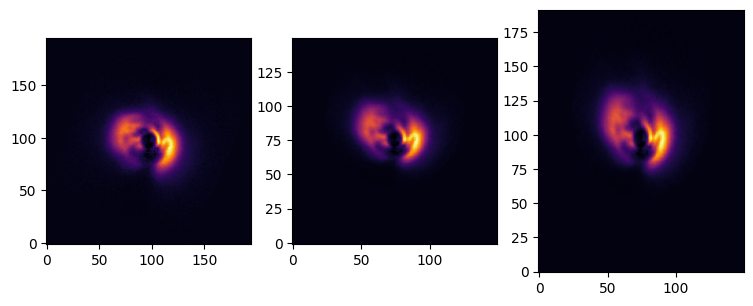

In [126]:
ATPyxDeproj = olddeprojection(ATPyx,
                          h0=0.1617*100,
                          r0=100,
                          alpha=1.219,
                          inc=38.5,
                          PA=22.11,
                          dist=7.632e7,
                          extent=300,
                          resolution=3.40305e-6,
                          )

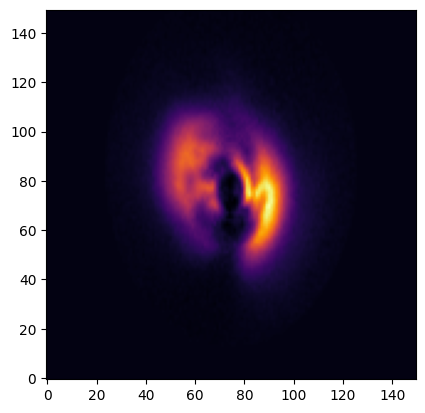

In [5]:
plt.imshow(ATPyxDeproj,origin='lower',cmap='inferno')
#x = 500400
#print(ATPyxDeproj[1][x],'-',ATPyxDeproj[2][x])

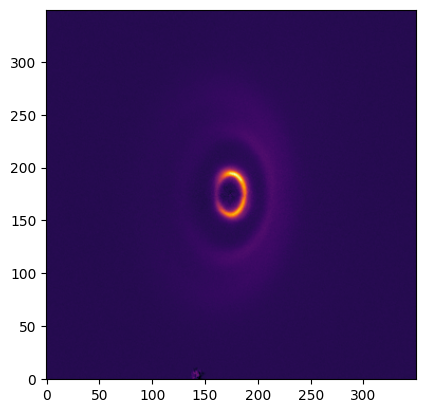

In [10]:
TYC = fits.open('fits/TYC_5709-354-1_2025-03-21_Q_phi.fits')[0].data


TYC = np.array(Cutout2D(TYC,(len(TYC[0])/2,len(TYC)/2),(350,350)).data)

plt.imshow(TYC,origin='lower',cmap='inferno',#vmin=0
          )

AU/Pixel =  0.16416619653202072


100%|███████████████████████████████████████| 3500/3500 [01:36<00:00, 36.21it/s]


'\nTYCDeproj60 = deprojection(TYC,\n                          h0=0.1617*100,\n                          r0=100,\n                          alpha=1.219,\n                          inc=60,\n                          PA=-90,\n                          dist=2.764e+7,\n                          extent=200,\n                          resolution=3.40305e-6,\n                          rebin=False)\n'

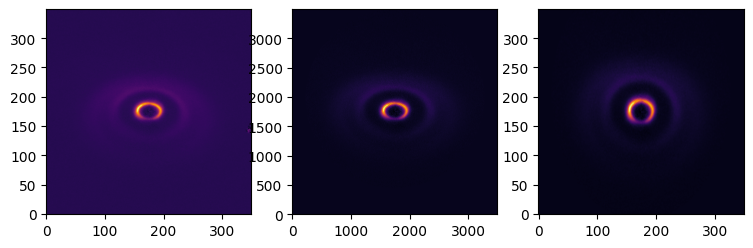

In [11]:
TYCDeproj42 = deprojection(TYC,
                          h0=0.1*100,
                          r0=100,
                          alpha=1.743,
                          inc=45,
                          PA=-90,
                          dist=2.764e+7,
                          extent=250,
                          resolution=3.40305e-6,
                          rebinyes=True)

'''
TYCDeproj60 = deprojection(TYC,
                          h0=0.1617*100,
                          r0=100,
                          alpha=1.219,
                          inc=60,
                          PA=-90,
                          dist=2.764e+7,
                          extent=200,
                          resolution=3.40305e-6,
                          rebin=False)
'''

In [28]:
print(TYCDeproj.shape)
plt.imshow(TYCDeproj,origin='lower',cmap='inferno',
           extent=[-0.1642*TYCDeproj.shape[1],0.1642*TYCDeproj.shape[1],-0.1642*TYCDeproj.shape[0],0.1642*TYCDeproj.shape[0]],#vmin=0
          )

theta = np.radians(np.linspace(0,360,1000))
r = 135
x_2 = r*np.cos(theta)-7
y_2 = r*np.sin(theta)+10
plt.plot(x_2,y_2,color='yellow',linestyle='dotted')

NameError: name 'TYCDeproj' is not defined

In [12]:
hdu = fits.PrimaryHDU(data=TYCDeproj42)
hdul = fits.HDUList([hdu])
hdu.writeto('TYCDeprojHBand45.fits')

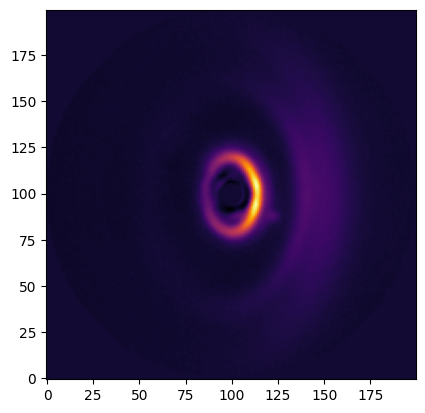

In [4]:
TYCRDI = np.array(fits.open('fits/idf_cube_klmodes10_threshold50_iternumber20_layer_19_rotated_-134.75.fits')[0].data)


#TYCRDI = np.array(Cutout2D(TYCRDI,(len(TYCRDI[0])/2,len(TYCRDI)/2),(350,350)).data)

plt.imshow(TYCRDI,origin='lower',cmap='inferno',#vmin=0
          )

AU/Pixel =  0.16416619653202072


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 78.67it/s]


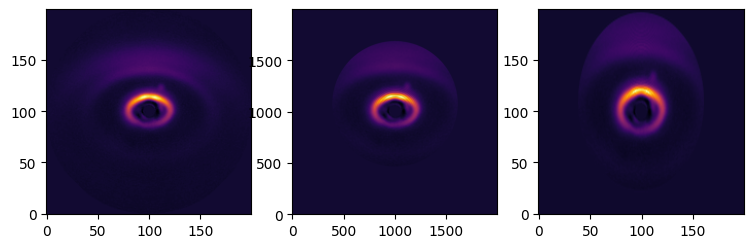

In [5]:
TYCDeproj45 = deprojection(TYCRDI,
                          h0=0.1617*100,
                          r0=100,
                          alpha=2.22,
                          inc=45,
                          PA=-90,
                          dist=2.764e+7,
                          extent=100,
                          resolution=3.40305e-6,
                          rebinyes=True)

(200, 200)


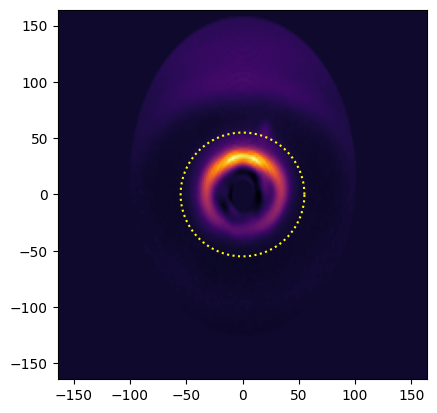

In [7]:
print(TYCDeproj45.shape)
plt.imshow(TYCDeproj45,origin='lower',cmap='inferno',
           extent=[-0.821*TYCDeproj45.shape[1],0.821*TYCDeproj45.shape[1],-0.821*TYCDeproj45.shape[0],0.821*TYCDeproj45.shape[0]],
           #vmin=0
          )

theta = np.radians(np.linspace(0,360,1000))
r = 55
x_2 = r*np.cos(theta)
y_2 = r*np.sin(theta)
plt.plot(x_2,y_2,color='yellow',linestyle='dotted')

In [9]:
hdu = fits.PrimaryHDU(data=TYCDeproj45)
hdul = fits.HDUList([hdu])
hdu.writeto('TYCDeprojKBandRDI45.fits')